In [4]:
# This notebook is to test the passive strap idea, which are after the feeds on either side. 


In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [19]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 13
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)
# capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
capfile = 'circ_model/S11_cap_81to111MHz_20cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF_13strap_2passive.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     13
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [20]:
print(myrfTWA.get_cap_S_given_f_and_lcap_from_internal_datatable(f=96, lcap=0.19, round_level=3))
print('--')
print(myrfTWA.S11_real_interpolator(96,0.19))

(96.0, 0.19, (0.7339611211391182-0.6791899670696561j), -8.952069823237783e-06, 9.339901629606818, 1940532.1471866672)
--
[[0.73396112]]


In [25]:
# try out the knew optimization function. Start with very low alpha and beta, and lamda largeish. 
#bounds = [(0.05, 0.154)]*7#[(0.02, 0.095)]*5
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45 #-30 #-45

# new settings 
alpha = 80e3 # 10,000 worked well 
gamma = 100 # 10000
lam1 = 100 #1000#10.017e6 # phase op
lam2 = 100# 40000 # power ratio op 
target_npar = 5.2#5.6 # TODO: change back to 5
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100
workers = 4

res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero_cancel_image_currents( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.15147989 0.14405892 0.08805247 0.07051607 0.08935888 0.0802439
 0.11960383]
Average absolute error is : 1.33e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.1514799  0.14405892 0.08805247 0.07051607 0.08935888 0.0802439
 0.11960383]
Average absolute error is : 1.33e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.15147989 0.14405893 0.08805247 0.07051607 0.08935888 0.0802439
 0.11960383]
Average absolute error is : 1.33e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.15147989 0.14405892 0.08805248 0.07051607 0.08935888 0.0802439
 0.11960383]
Average absolute error is : 1.33e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.15147989 0.14405892 0.08805247 0.07051608 0.08935888 0.0802439
 0.11960383]
Average absolute error is : 1.33e+03
------------------------------

In [34]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.1514798940484278, 0.14405892411361965, 0.08805247022475939, 0.07051607061668963, 0.08935888096867531, 0.08024390374810547, 0.11960383110744062]
The phase difference is 174.090487080337 deg
The power ratio I_2^2 / I_1^2 = 3.811526189270717


final lengths: [0.1514798940484278, 0.14405892411361965, 0.08805247022475939, 0.07051607061668963, 0.08935888096867531, 0.08024390374810547, 0.11960383110744062]


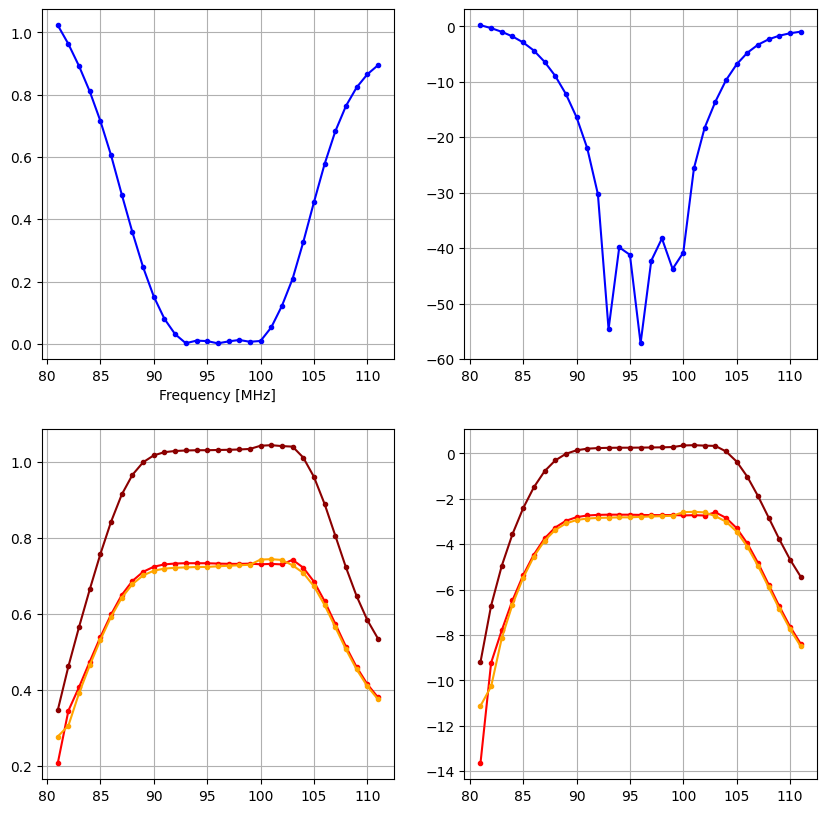

In [27]:
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,0].set_xlabel('Frequency [MHz]')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

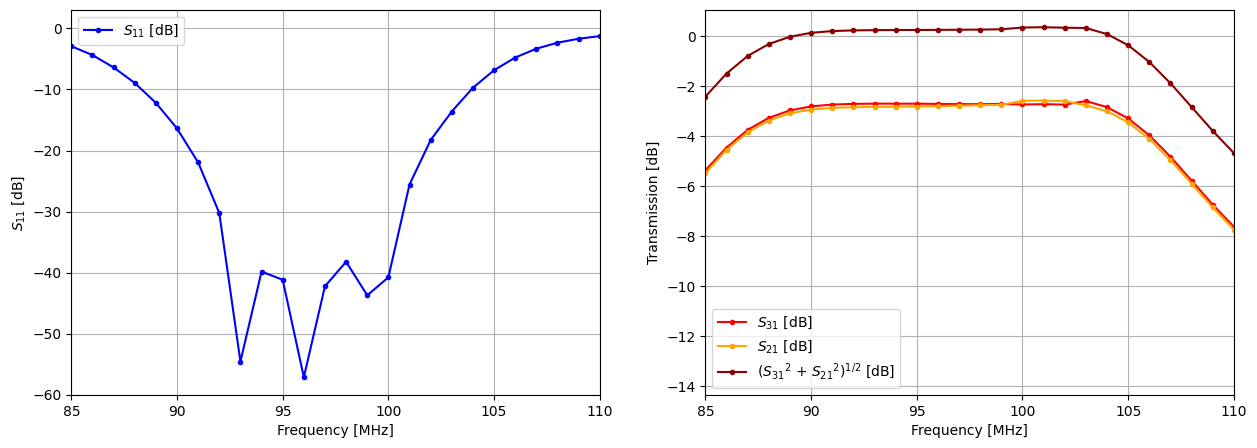

In [28]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label=r'$S_{11}$ [dB]')
ax[1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red', label=r'$S_{31}$ [dB]')
ax[1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange', label=r'$S_{21}$ [dB]')
ax[1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred', label=r'(${S_{31}}^2$ + ${S_{21}}^2)^{1/2}$ [dB]')
ax[0].set_xlabel('Frequency [MHz]')
ax[1].set_xlabel('Frequency [MHz]')
ax[0].set_ylabel(r'$S_{11}$ [dB]')
ax[1].set_ylabel(r'Transmission [dB]')
ax[0].set_xlim(85,110)
ax[1].set_xlim(85,110)
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()

port indicies [1, 3, 5]
[ 0.12711765-0.2111237j  -0.12711765+0.2111237j   0.06442951-0.06064342j
 -0.06442951+0.06064342j  0.05784588-0.05294972j -0.05784588+0.05294972j
  0.04541   -0.40721666j -0.04541   +0.40721666j -0.00452003+0.1231052j
  0.00452003-0.1231052j  -0.12138072+0.27008257j  0.12138072-0.27008257j
 -0.12851395+0.25219909j  0.12851395-0.25219909j -0.19473001+0.3425643j
  0.19473001-0.3425643j  -0.08771601+0.1463657j   0.08771601-0.1463657j
  0.06604137-0.14049173j -0.06604137+0.14049173j -0.08331331+0.12525895j
  0.08331331-0.12525895j -0.18376515+0.30011358j  0.18376515-0.30011358j
 -0.12236875+0.21931415j  0.12236875-0.21931415j -0.11475539+0.23550239j
  0.11475539-0.23550239j -0.00553313+0.10905926j  0.00553313-0.10905926j
  0.05345813-0.35650184j -0.05345813+0.35650184j]
--
[-0.09962473-0.13362561j  0.22032453+0.23946751j -0.20158228+0.21597147j
 -0.17252845-0.01228259j -0.06217126-0.24199524j  0.16355988-0.09937033j
  0.28522811+0.22543738j  0.16602988-0.09499349j -

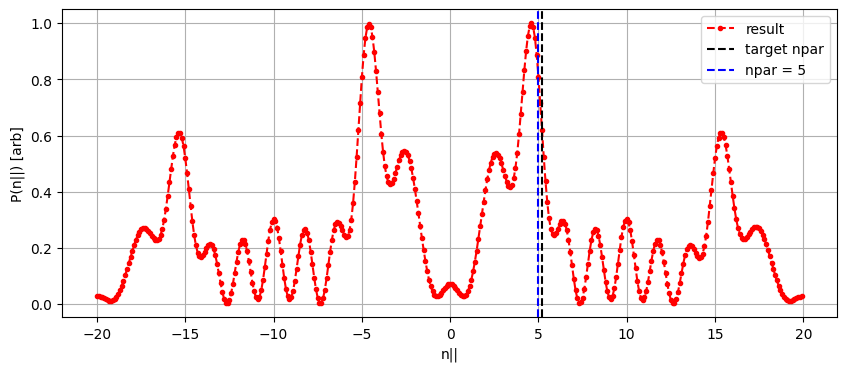

In [29]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

In [77]:
# area to test out the new ideal profile code 
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
omega = 300000 # 300,000 worked ok 
lam1 = 100000 # phase op
lam2 = 100000 # power ratio op 
target_npar = 7#5.2#5.6 # TODO: change back to 5
sigma = 2# .8 was the setting befor 
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 7]#[0, 10]
num_npars = 100
workers = 4
custom_npar_array = np.append(np.append(
                                        np.linspace(0, target_npar - sigma, 50), 
                                        np.linspace(target_npar - sigma, target_npar - sigma/5, 5)),
                              np.append(
                                        np.linspace(target_npar - sigma/5, target_npar + sigma/5, 30),
                                        np.linspace(target_npar + sigma/5, target_npar + sigma, 5)))
# custom_npar_array = np.append(np.append(
#                                         np.linspace(0, 0.1, 50), 
#                                         np.linspace(target_npar - sigma, target_npar - sigma/5, 5)),
#                               np.append(
#                                         np.linspace(target_npar - sigma/5, target_npar + sigma/5, 30),
#                                         np.linspace(target_npar + sigma/5, target_npar + sigma, 5)))
# custom_npar_array = np.append(np.append(
#                                         np.linspace(0, 0.5, 50), 
#                                         np.linspace(target_npar - sigma, target_npar - sigma/5, 5)),
#                               np.append(
#                                         np.linspace(target_npar - sigma/5, target_npar + sigma/5, 30),
#                                         np.linspace(target_npar + sigma/5, target_npar + sigma, 5)))
use_custom_npar = True

Text(0, 0.5, 'Power [a.u.]')

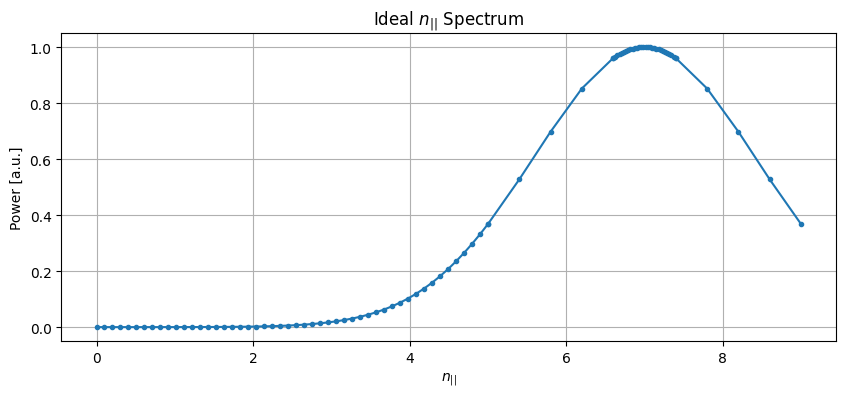

In [78]:
# plot of the ideal npar spectrum 
npar_array_for_ideal = np.linspace(npar_bounds[0], npar_bounds[1], num_npars)
npar_array_for_ideal = custom_npar_array
ideal_spec = myrfTWA.normalized_npar_ideal(npar_array_for_ideal, ntarget=target_npar, sigma=sigma)
plt.figure(figsize=(10,4))
plt.plot(npar_array_for_ideal, ideal_spec, marker='.')
plt.grid()
plt.title(r'Ideal $n_{||}$ Spectrum')
plt.xlabel(r'$n_{||}$')
plt.ylabel('Power [a.u.]')

In [79]:

res = myrfTWA.run_differential_evolution_global_op_total_npar_spectrum_match_cancel_image_currents( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            omega_npar_op=omega,
                                            sigma_for_ideal_npar=sigma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            custom_npar_array=custom_npar_array,
                                            use_custom_npar_array=use_custom_npar,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)


----------------------------------------
i_iter = 1
New simulation.
Point is: [0.19020013 0.09038854 0.11668122 0.1906923  0.11250098 0.0880967
 0.18535145]
Average absolute error is : 5.79e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.19020014 0.09038854 0.11668122 0.1906923  0.11250098 0.0880967
 0.18535145]
Average absolute error is : 5.79e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.19020013 0.09038855 0.11668122 0.1906923  0.11250098 0.0880967
 0.18535145]
Average absolute error is : 5.79e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.19020013 0.09038854 0.11668123 0.1906923  0.11250098 0.0880967
 0.18535145]
Average absolute error is : 5.79e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.19020013 0.09038854 0.11668122 0.19069231 0.11250098 0.0880967
 0.18535145]
Average absolute error is : 5.79e+04
------------------------------

In [80]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist() 
#lengths_found = [0.10713031085480045, 0.07653635344299041, 0.10334199789158666, 0.06104064775976781, 0.10681852406461352, 0.194, 0.09445569044738547]
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.19198770687344568, 0.08937481776563613, 0.1168618795759828, 0.19341574704704742, 0.11202761292214672, 0.08559908028676885, 0.1885703938981034]
The phase difference is 175.182135914411 deg
The power ratio I_2^2 / I_1^2 = 1.9823006731718527


final lengths: [0.19198770687344568, 0.08937481776563613, 0.1168618795759828, 0.19341574704704742, 0.11202761292214672, 0.08559908028676885, 0.1885703938981034]


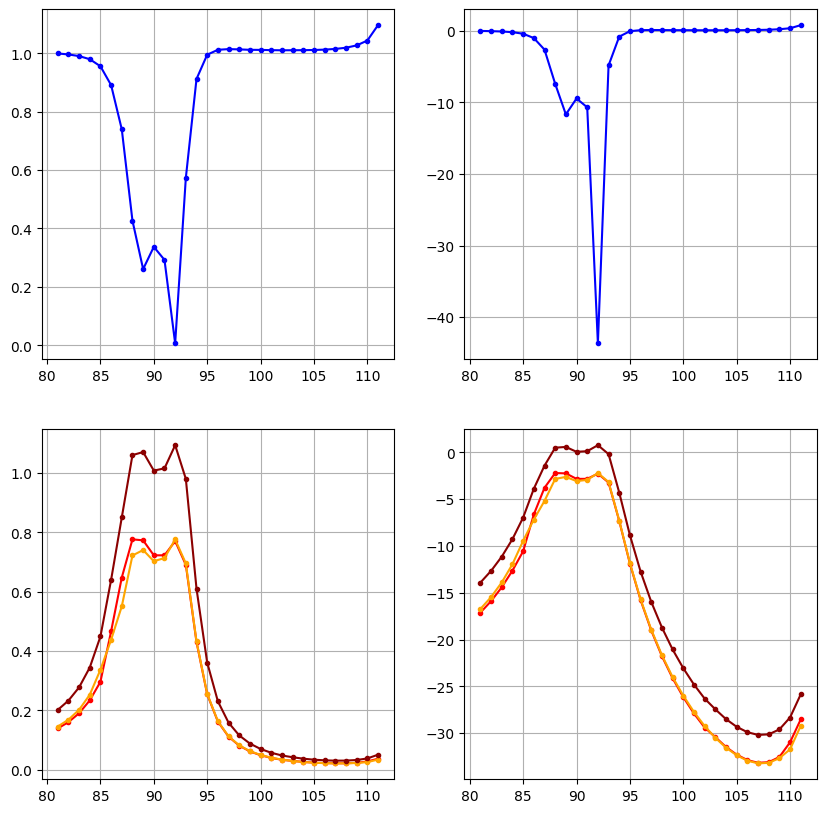

In [81]:
#lengths_found = [0.194, 0.1313866735714255, 0.08289423924416277, 0.06213359442830035, 0.09767239308875371, 0.1175386770606046, 0.14438872750235227]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.4372056 -0.18463032j -0.4372056 +0.18463032j -0.04130073+0.00605624j
  0.04130073-0.00605624j -0.04199227+0.00726062j  0.04199227-0.00726062j
 -0.04063723+0.04656202j  0.04063723-0.04656202j  0.02096786-0.02780286j
 -0.02096786+0.02780286j  0.14330482-0.07506254j -0.14330482+0.07506254j
  0.16872471-0.05011641j -0.16872471+0.05011641j -0.24729676+0.10095807j
  0.24729676-0.10095807j -0.21968975+0.09087714j  0.21968975-0.09087714j
 -0.3389599 +0.14157107j  0.3389599 -0.14157107j -0.22408185+0.097028j
  0.22408185-0.097028j   -0.2522045 +0.11107972j  0.2522045 -0.11107972j
  0.17354092-0.05508728j -0.17354092+0.05508728j  0.14431615-0.08023943j
 -0.14431615+0.08023943j  0.02067626-0.02892389j -0.02067626+0.02892389j
 -0.04041014+0.04818283j  0.04041014-0.04818283j]
--
[ 2.73777065e-02-1.48889613e-02j -3.66493940e-02+2.41261672e-02j
 -1.47910049e-01-1.55652203e-02j  2.79218961e-01-5.18263553e-02j
 -4.04277359e-01+1.11249803e-01j -3.66594981e-03+5.80783519e-03j


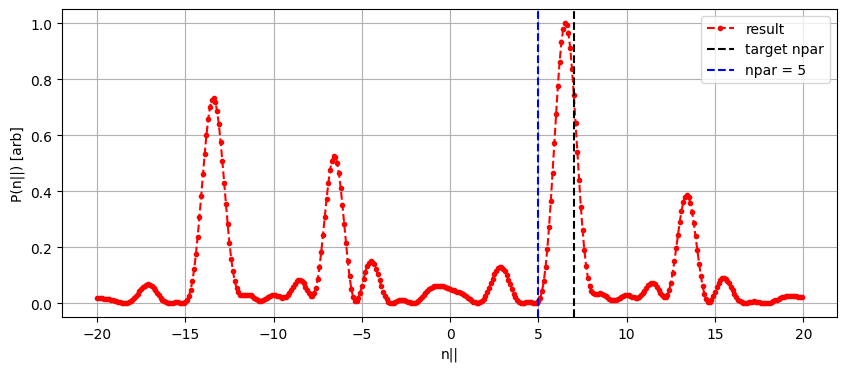

In [82]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(-10, 0, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

[-0.15854947  0.81468461 -0.9666257  -0.05841729  0.91452256  0.67922463
 -0.08396156 -0.7465004   0.91610871 -0.05630083 -0.96701109  0.81368324
 -0.15960282]


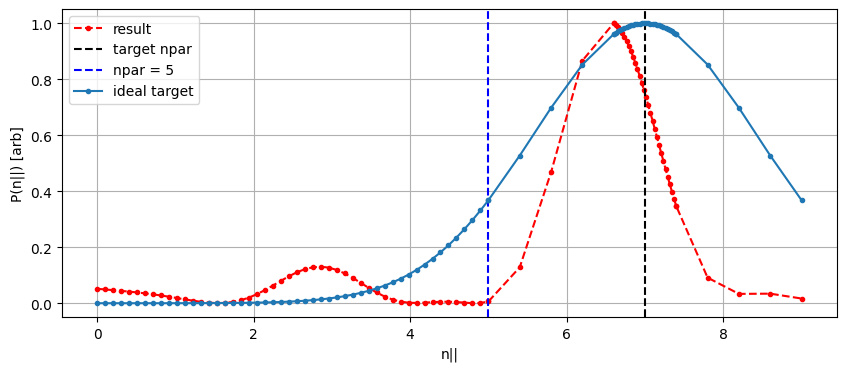

In [84]:

print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array_for_ideal.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array_for_ideal[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array_for_ideal, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')

plt.plot(npar_array_for_ideal, ideal_spec, marker='.', label='ideal target')

plt.legend()

In [53]:
# New area for secondary peak cancelation 
# try out the knew optimization function. Start with very low alpha and beta, and lamda largeish. 
#bounds = [(0.05, 0.154)]*7#[(0.02, 0.095)]*5
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (94,98)#(92, 100)
s11cutoff = -35 # TODO this used to be -45 dB 

# new settings 
alpha = 80e3#200000 # 10,000 worked well 
gamma = 10e3#100000
lam1 = 1000#1000#10.017e6 # phase op
lam2 = 40e3#40000 # power ratio op 
target_npar = 5.2#5.6 # TODO: change back to 5
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100
workers = 4

# secondary peak cancelation 
npar_secondary_peak_cancelation = np.linspace(0.88,3.111, 10)#np.append(np.linspace(0.88,3.111, 10), np.linspace(6,7.5, 10))
epsilon = 30e3#15007.012

res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero_cancel_image_currents_reduce_secondary_peaks( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            npar_array_secondary_peak_cancelation=npar_secondary_peak_cancelation,
                                            epsilon_secondary_peak_cancelation=epsilon,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.13371774 0.13926086 0.10947309 0.11306282 0.10266065 0.12094428
 0.14611278]
Average absolute error is : 3.42e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.13371775 0.13926086 0.10947309 0.11306282 0.10266065 0.12094428
 0.14611278]
Average absolute error is : 3.42e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.13371774 0.13926087 0.10947309 0.11306282 0.10266065 0.12094428
 0.14611278]
Average absolute error is : 3.42e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.13371774 0.13926086 0.1094731  0.11306282 0.10266065 0.12094428
 0.14611278]
Average absolute error is : 3.42e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.13371774 0.13926086 0.10947309 0.11306283 0.10266065 0.12094428
 0.14611278]
Average absolute error is : 3.42e+03
-------------------------

In [54]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.13371773818607283, 0.13926086327497594, 0.10947308897987523, 0.11306281861604961, 0.10266064887365167, 0.12094428065959732, 0.14611277556486468]
The phase difference is 174.87617320850262 deg
The power ratio I_2^2 / I_1^2 = 2.0219732463201794


final lengths: [0.13371773818607283, 0.13926086327497594, 0.10947308897987523, 0.11306281861604961, 0.10266064887365167, 0.12094428065959732, 0.14611277556486468]


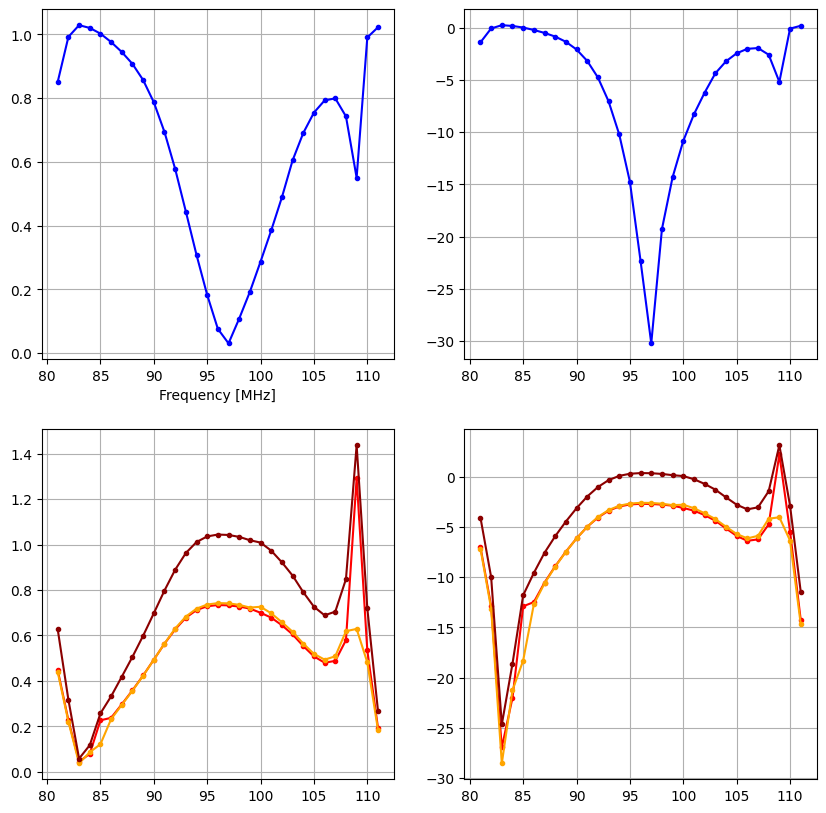

In [55]:
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,0].set_xlabel('Frequency [MHz]')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.50069718-0.082822j   -0.50069718+0.082822j    0.04791274+0.03436535j
 -0.04791274-0.03436535j  0.04495627+0.03559775j -0.04495627-0.03559775j
 -0.63626998-0.00989613j  0.63626998+0.00989613j -0.07821128+0.01236649j
  0.07821128-0.01236649j  0.41492026-0.06663608j -0.41492026+0.06663608j
  0.49656276-0.07851937j -0.49656276+0.07851937j  0.02284714-0.00208109j
 -0.02284714+0.00208109j -0.50175267+0.08052284j  0.50175267-0.08052284j
 -0.42158844+0.06773869j  0.42158844-0.06773869j -0.50739123+0.08932493j
  0.50739123-0.08932493j  0.0218859 +0.00124016j -0.0218859 -0.00124016j
  0.49609871-0.07929775j -0.49609871+0.07929775j  0.4150932 -0.07246878j
 -0.4150932 +0.07246878j -0.07652634+0.00838873j  0.07652634-0.00838873j
 -0.63212382-0.00321498j  0.63212382+0.00321498j]
--
[-0.06090121+0.2129767j   0.05920651-0.30936846j  0.41631074-0.05760065j
 -0.15357429+0.25550675j -0.34227165-0.02184898j  0.13169012-0.26045809j
  0.38572147+0.26387275j  0.13444352-0.26910333

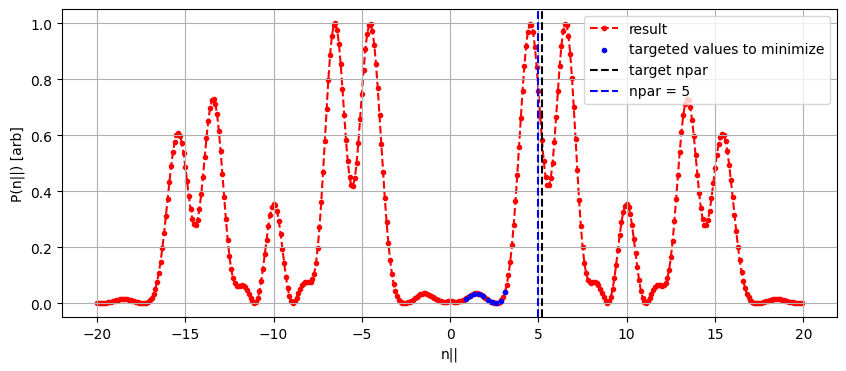

In [56]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

result_circ_model_secondary_peak = np.array([], dtype='complex')
for i in range(npar_secondary_peak_cancelation.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_secondary_peak_cancelation[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model_secondary_peak = np.append(result_circ_model_secondary_peak, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', 
         label='result', marker='.', zorder=1)
plt.scatter(npar_secondary_peak_cancelation, result_circ_model_secondary_peak/np.max(np.real(result_circ_model)), 
            color='blue', marker='.', label='targeted values to minimize', zorder=2)
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

print('npar_secondary_peak_cancelation', npar_secondary_peak_cancelation)

In [3]:
# print(lengths_found)
# print(myrfTWA.symetric_mode)
# npar_bounds = [-10, 10]
# npar_array = np.linspace(npar_bounds[0], npar_bounds[1], num_npars)
# npar_spec_found = myrfTWA.get_npar_spectrum(lengths=lengths_found.copy(),
#                                             npar_bounds=npar_bounds, #myrfTWA.npar_bounds_for_npar_op,
#                                             freq=myrfTWA.freq_for_npar_op,
#                                             num_npars=myrfTWA.num_npars_for_npar_op,
#                                             power=[1,0,0],
#                                             phase=[0,0,0],
#                                             symetric_mode=myrfTWA.symetric_mode,
#                                             one_cap_type_mode=myrfTWA.one_cap_type_mode,
#                                             end_cap_mode=myrfTWA.end_cap_mode)

# plt.plot(npar_array, npar_spec_found)

[132.18194679 -52.43821791 -33.13329797 129.08431771 143.43960952
 -45.25003752  75.16914223 -46.71473045 141.97351779 127.48678735
 -34.59258214 -53.93272009 130.716615  ]
d:  0.15625
wstrap:  0.08


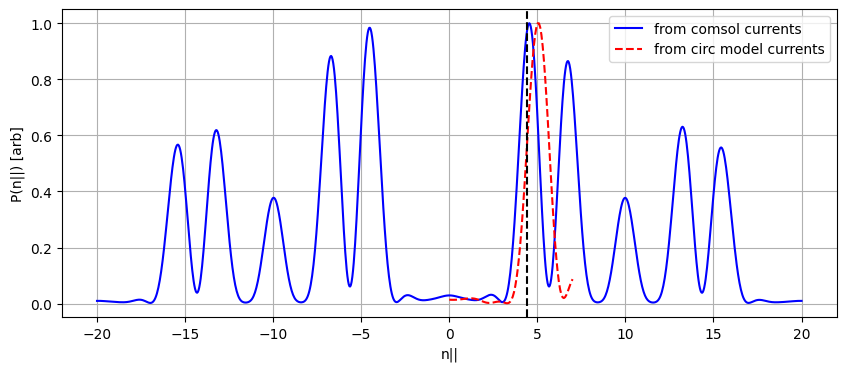

In [39]:
cap_currents = np.array([-0.0035685+0.0039380*1j, 7.9119E-4-0.0010288*1j, 0.0079662-0.0051997*1j, -5.5829E-4+6.8736E-4*1j,	-0.0098376+0.0072955*1j, 0.0048025-0.0048446*1j, 4.8006E-4+0.0018130*1j, 0.0046613-0.0049490*1j, -0.0095605+0.0074766*1j, -5.3043E-4+6.9160E-4*1j, 0.0077564-0.0053493*1j, 7.5383E-4-0.0010350*1j, -0.0034380+0.0039947*1j])

cap_phases = myrfTWA.get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])
npar_array = np.linspace(-20, 20, 1000)

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array_for_ideal, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

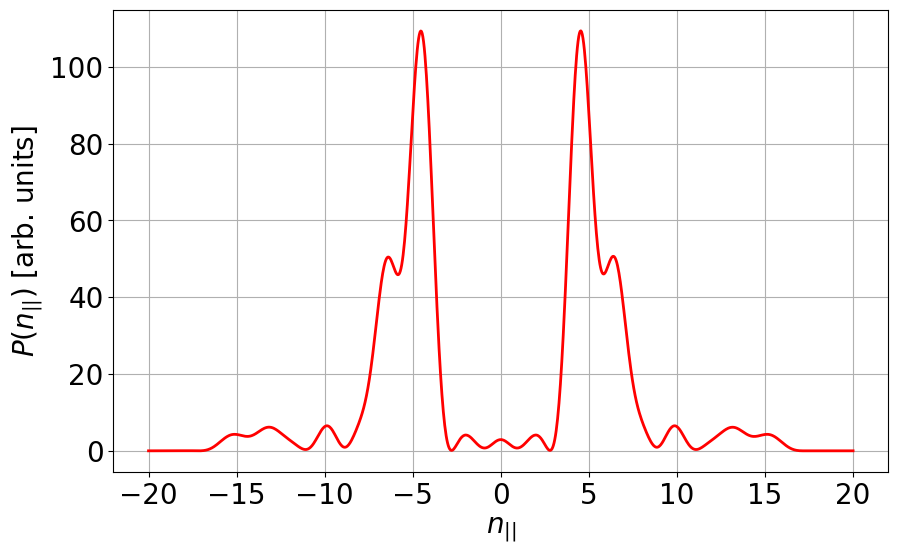

In [3]:
# figure from comsol npar plot 
plt.figure(figsize=(10,6))
data_for_npar_plot = np.loadtxt('npar_plot2.txt')
npar = data_for_npar_plot[:,0]
powers = data_for_npar_plot[:,1]
plt.plot(npar, powers, color='red', linewidth=2)
plt.grid()
plt.xlabel(r'$n_{||}$', fontsize=20)
plt.ylabel(r'$P(n_{||})$ [arb. units]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size

[-27.29430251]


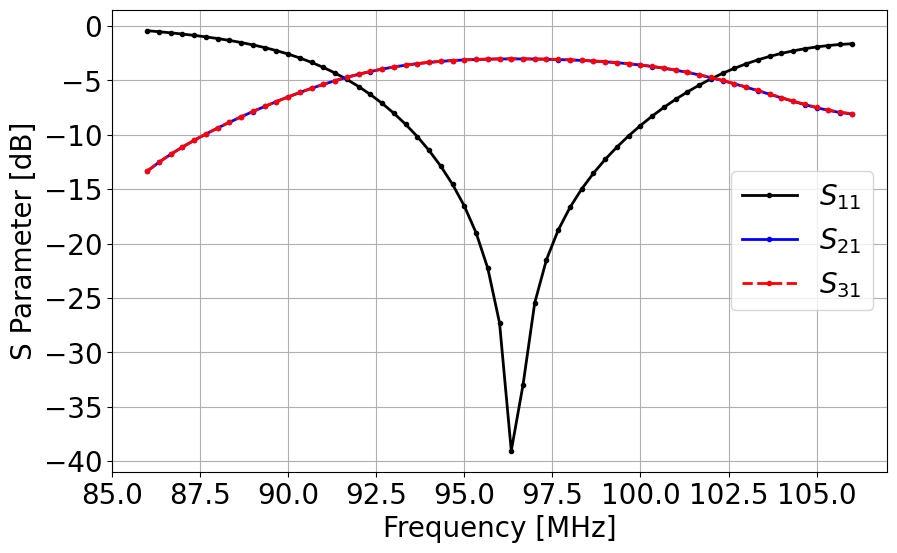

In [6]:
# build up the S11, S21, S31 matrix 
filename = 'Sparams.txt'
dataset = np.loadtxt(filename)
fd = dataset[:, 0]
S11db = dataset[:,1]
S21db = dataset[:,2]
S31db = dataset[:,3]

plt.figure(figsize=(10,6))
plt.plot(fd, S11db, color='black', linewidth=2, label=r'$S_{11}$', marker='.')
plt.plot(fd, S21db, color='blue', linewidth=2, label=r'$S_{21}$', marker='.')
plt.plot(fd, S31db, color='red', linestyle='--', linewidth=2, label=r'$S_{31}$', marker='.')
plt.grid()
plt.xlabel('Frequency [MHz]', fontsize=20)
plt.ylabel(r'S Parameter [dB]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size
plt.legend(fontsize=20, loc='right')

print(S11db[np.where(fd == 96)])

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80')])

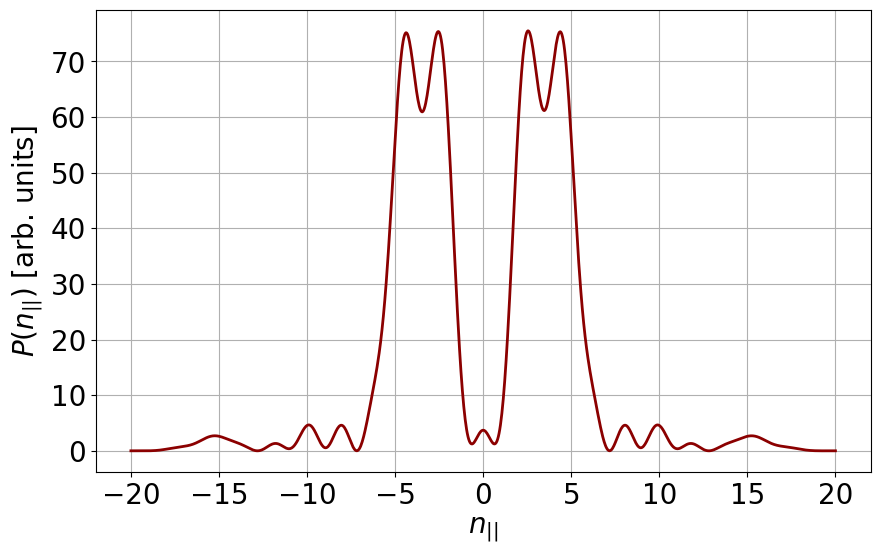

In [33]:
# unoptomized npar
# figure from comsol npar plot 
plt.figure(figsize=(10,6))
data_for_npar_plot = np.loadtxt('npar_plot_unoptomized.txt')
npar = data_for_npar_plot[:,0]
powers = data_for_npar_plot[:,1]
plt.plot(npar, powers, color='darkred', linewidth=2)
plt.grid()
plt.xlabel(r'$n_{||}$', fontsize=20)
plt.ylabel(r'$P(n_{||})$ [arb. units]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size

[-34.3231697]


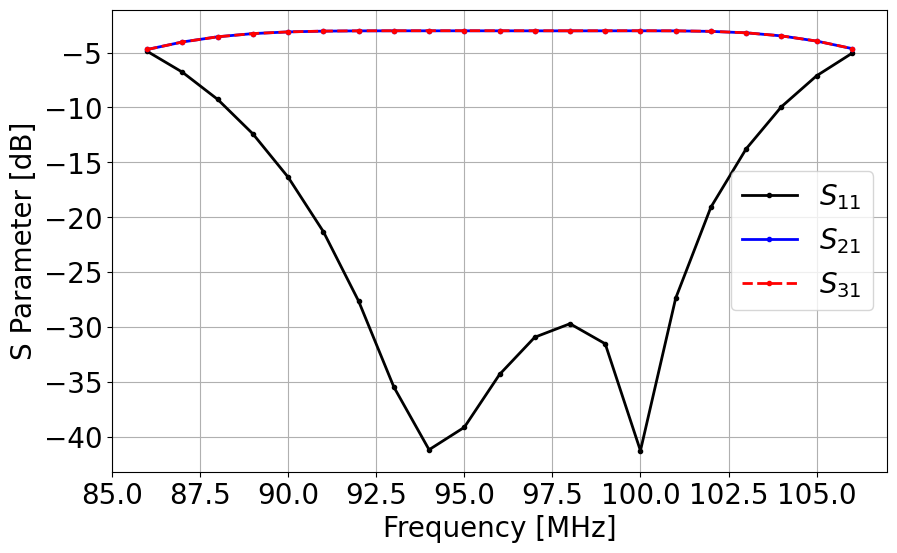

In [32]:
# S11 unoptomized 
# build up the S11, S21, S31 matrix 
filename = 'S11_unoptomized.txt'
dataset = np.loadtxt(filename)
fd = dataset[:, 0]
S11db = dataset[:,1]
S21db = dataset[:,2]
S31db = dataset[:,3]

plt.figure(figsize=(10,6))
plt.plot(fd, S11db, color='black', linewidth=2, label=r'$S_{11}$', marker='.')
plt.plot(fd, S21db, color='blue', linewidth=2, label=r'$S_{21}$', marker='.')
plt.plot(fd, S31db, color='red', linestyle='--', linewidth=2, label=r'$S_{31}$', marker='.')
plt.grid()
plt.xlabel('Frequency [MHz]', fontsize=20)
plt.ylabel(r'S Parameter [dB]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size
plt.legend(fontsize=20, loc='right')

print(S11db[np.where(fd == 96)])